## Graph Convolution

In [22]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import PandasTools

import numpy as np

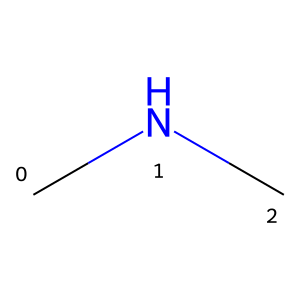

In [31]:
mol = Chem.MolFromSmiles('CNC')   # dimethyl amine

def draw_mol(mol):
    dos = Draw.MolDrawOptions()
    dos.addAtomIndices = True
    return Draw.MolToImage(mol, options=dos)

draw_mol(mol)

Graph only knows connections. 

Convolution is concerned with getting chemical info into this.

### Adjacency Matrix

In [32]:
A = Chem.GetAdjacencyMatrix(mol)
A = np.asmatrix(A)
A

matrix([[0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]], dtype=int32)

In [33]:
# One-hot encoding of atoms
C = [1, 0]
N = [0, 1]
X = np.array([C, N, C])
X

array([[1, 0],
       [0, 1],
       [1, 0]])

Convolution is the multiplication of these:

In [34]:
'''
   C   N
C  0   1
N  2   0
C  0   1

atom 0 is bound to 0 C and 1 N
atom 1 is bound to 2 C and 0 N
atom 2 is bound to 0 C and 1 N
'''

A @ X        # @ for matrix multiplication


matrix([[0, 1],
        [2, 0],
        [0, 1]])

### Identity Matrix

In [35]:
I = np.matrix(np.eye(A.shape[0])) 
A_hat = A + I
A_hat

matrix([[1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.]])

In [ ]:
''' What the atom is and is bonded to!!!
   C   N
C  0   1
N  2   0
C  0   1

atom 0 is bound to 0 C and 1 N and is a C(1st column)
atom 1 is bound to 2 C and 0 N and is a N(2nd column)
atom 2 is bound to 0 C and 1 N and is a C(1st column)
'''

A_hat @ X

matrix([[1., 1.],
        [2., 1.],
        [1., 1.]])

### Normalization
For larger systems, these values are big... problem for activation functions

Normalization ensures the numbers in this matrix are relatively small

In [39]:
D_hat = np.array(np.sum(A_hat, axis=0))[0] # sum over rows of A_hat
D_hat

array([2., 3., 2.])

In [40]:
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[2., 0., 0.],
        [0., 3., 0.],
        [0., 0., 2.]])

In [42]:
# inverse of D_hat to normalize
D_hat**(-1) * A_hat * X

matrix([[0.5       , 0.5       ],
        [0.66666667, 0.33333333],
        [0.5       , 0.5       ]])

In [46]:
D_hat_inv = np.sqrt(D_hat**(-1))
H = D_hat_inv * A_hat * D_hat_inv * X
H

matrix([[0.5       , 0.40824829],
        [0.81649658, 0.33333333],
        [0.5       , 0.40824829]])

### Weights

In [47]:
np.random.seed(0)
# number of descriptors * number of filters
W = 2 * np.random.rand(2, 5) - 1    # 2 features, 5 layers, -1 so weights are between 0 and 1
W = np.asmatrix(W)
W

matrix([[ 0.09762701,  0.43037873,  0.20552675,  0.08976637, -0.1526904 ],
        [ 0.29178823, -0.12482558,  0.783546  ,  0.92732552, -0.23311696]])

In [48]:
Z = H * W
Z

matrix([[ 0.16793555,  0.16422954,  0.42264469,  0.42346224, -0.1715148 ],
        [ 0.17697486,  0.30979424,  0.42899389,  0.38240244, -0.20237684],
        [ 0.16793555,  0.16422954,  0.42264469,  0.42346224, -0.1715148 ]])

### Pass to Activation Function

In [ ]:
def relu(x):
    return np.maximum(0, x) # 0 if x < 0, else x

relu(Z)

matrix([[0.16793555, 0.16422954, 0.42264469, 0.42346224, 0.        ],
        [0.17697486, 0.30979424, 0.42899389, 0.38240244, 0.        ],
        [0.16793555, 0.16422954, 0.42264469, 0.42346224, 0.        ]])

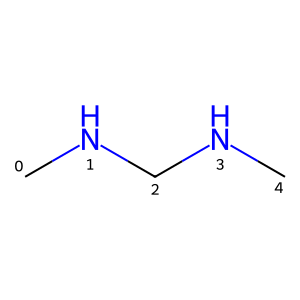

In [51]:
mol2 = Chem.MolFromSmiles('CNCNC')
draw_mol(mol2)

In [ ]:
A = Chem.GetAdjacencyMatrix(mol2)
A = np.asmatrix(A)

# One-hot encoding of atoms
C = [1, 0]
N = [0, 1]
X = np.array([C, N, C, N, C])

H1 = A * X
print(H1) # how many things an atom is bonded to  e.g  1, then 2, then 2, then 2, then 1

H2 = A * H1
print(H2)

[[0 1]
 [2 0]
 [0 2]
 [2 0]
 [0 1]]
[[2 0]
 [0 3]
 [4 0]
 [0 3]
 [2 0]]


By going through several convolutional layers, we can get info about bonding further and further from the atom